In [1]:
### Loading the Reuters dataset

from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

print(len(train_data))
print(len(test_data))
print(train_data[10])

8982
2246
[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [2]:
### Decoding newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])

print(decoded_newswire[4:])

label_index = reuters.get_label_names()
print(label_index)
print(label_index[train_labels[0]])


? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
('cocoa', 'grain', 'veg-oil', 'earn', 'acq', 'wheat', 'copper', 'housing', 'money-supply', 'coffee', 'sugar', 'trade', 'reserves', 'ship', 'cotton', 'carcass', 'crude', 'nat-gas', 'cpi', 'money-fx', 'interest', 'gnp', 'meal-feed', 'alum', 'oilseed', 'gold', 'tin', 'strategic-metal', 'livestock', 'retail', 'ipi', 'iron-steel', 'rubber', 'heat', 'jobs', 'lei', 'bop', 'zinc', 'orange', 'pet-chem', 'dlr', 'gas', 'silver', 'wpi', 'hog', 'lead')
earn


**Preparação dos dados**

In [3]:
### Encoding the data

import numpy as np
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Para vetorizar os rótulos, existem duas possibilidades: você pode converter a lista de rótulos em um tensor de números inteiros, ou pode usar a codificação *one-hot*. A codificação *one-hot* é um formato amplamente utilizado para dados categóricos, também chamado de **codificação categórica**. Neste caso, a codificação *one-hot* dos rótulos consiste em incorporar cada rótulo como um vetor todo-zero com um 1 no local do índice do rótulo. Aqui está um exemplo:

In [4]:
def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

#there is a built-in way to do this in Keras
from keras.utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

**Construindo a rede**

Esse problema de classificação de tópicos parece semelhante ao problema anterior de classificação de resenha de filmes: em ambos os casos, você está tentando classificar trechos curtos de texto. Mas há uma nova restrição aqui: o número de classes de saída aumentou de 2 para 46. O número de dimensões do espaço de saída é muito maior.

Em uma pilha de camadas `Dense` como a que estamos usando, cada camada só pode acessar informações presentes na saída da camada anterior. Se uma camada descartar algumas informações relevantes para o problema de classificação, essas informações nunca poderão ser recuperadas por camadas posteriores: cada camada pode se tornar potencialmente um gargalo de informação. No exemplo anterior, usamos camadas intermediárias de 16 dimensões, mas um espaço de 16 dimensões pode ser muito limitado para aprender a separar 46 classes diferentes: essas camadas pequenas podem atuar como gargalos de informação, descartando permanentemente informações relevantes.

Por esse motivo, usaremos camadas maiores, com 64 unidades.

In [5]:
### Defining the model

from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

C:\Users\gugat\PycharmProjects\PUC\venv\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Existem mais duas coisas que se deve observar sobre esta arquitetura:

- A rede encerra com uma camada `Dense` de tamanho 46. Isso significa que, para cada amostra de entrada, a rede produzirá um vetor de 46 dimensões. Cada entrada neste vetor (cada dimensão) codificará uma classe de saída diferente.
- A última camada usa uma ativação `softmax`. Vimos esse padrão no exemplo do MNIST. Isso significa que a rede produzirá uma **distribuição de probabilidade** sobre as 46 diferentes classes de saída - para cada amostra de entrada, a rede produzirá um vetor de saída de 46 dimensões, onde `output[i]` é a probabilidade de que a amostra pertença à classe i. As 46 pontuações somarão 1.

A melhor função de perda a ser usada neste caso é `categorical_crossentropy`. Ela mede a distância entre duas distribuições de probabilidade: neste caso, entre a distribuição de probabilidade produzida pela rede e a verdadeira distribuição dos rótulos. Ao minimizar a distância entre essas duas distribuições, você treina a rede para produzir algo o mais próximo possível dos verdadeiros rótulos.

In [6]:
### Compiling the model

model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

**Validando a abordagem**

In [7]:
### Setting aside a validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

### Training the model
history = model.fit(partial_x_train, partial_y_train,
epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4119 - loss: 3.1366 - val_accuracy: 0.5940 - val_loss: 1.8465
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6415 - loss: 1.6277 - val_accuracy: 0.6930 - val_loss: 1.3874
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7299 - loss: 1.2435 - val_accuracy: 0.7190 - val_loss: 1.2329
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7845 - loss: 0.9969 - val_accuracy: 0.7640 - val_loss: 1.0890
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8229 - loss: 0.8393 - val_accuracy: 0.7820 - val_loss: 1.0125
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8456 - loss: 0.7133 - val_accuracy: 0.7980 - val_loss: 0.9482
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8730 - loss: 0.5805 - val_accuracy: 0.8060 - val_loss: 0.9096
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8955 - loss: 0.4949 - val_accuracy: 0.8080 - val_los

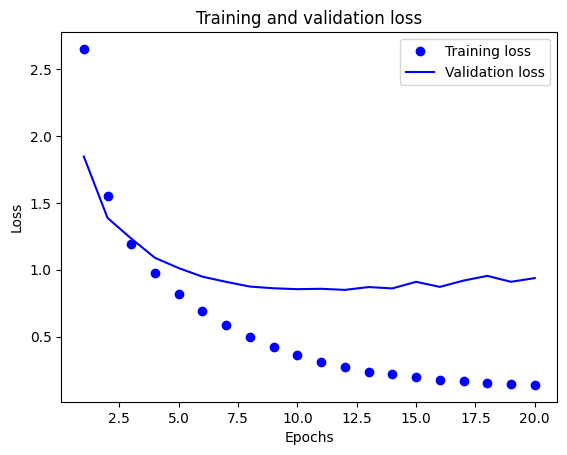

In [8]:
###Plotting the training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


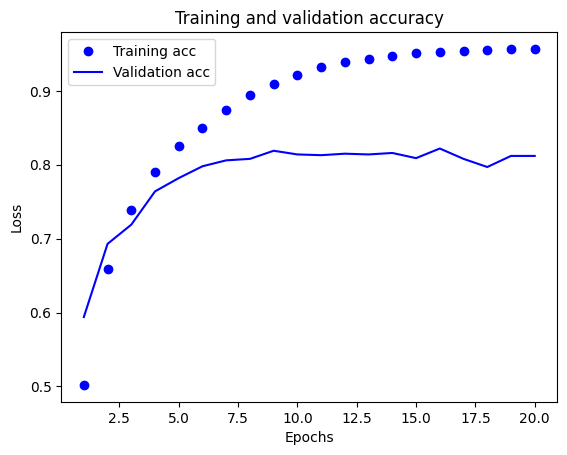

In [9]:
###Plotting the training and validation accuracy
plt.clf()
history_dict = history.history
print(history_dict.keys())
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

A rede começa a sofrer *overfitting* após nove épocas. Vamos treinar uma nova rede do zero por nove épocas e depois avaliá-la no conjunto de teste.

In [10]:
### Retraining a model from scratch

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
partial_y_train,
epochs=9,
batch_size=512,
validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
print(results)

C:\Users\gugat\PycharmProjects\PUC\venv\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4409 - loss: 3.0992 - val_accuracy: 0.6390 - val_loss: 1.7730
Epoch 2/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6820 - loss: 1.5680 - val_accuracy: 0.6920 - val_loss: 1.3599
Epoch 3/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7263 - loss: 1.2260 - val_accuracy: 0.7260 - val_loss: 1.1981
Epoch 4/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7790 - loss: 0.9967 - val_accuracy: 0.7600 - val_loss: 1.0900
Epoch 5/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8215 - loss: 0.8084 - val_accuracy: 0.7840 - val_loss: 1.0144
Epoch 6/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8547 - loss: 0.6757 - val_accuracy: 0.7890 - val_loss: 0.9550
Epoch 7/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8850 - loss: 0.5582 - val_accuracy: 0.8070 - val_loss: 0.9216
Epoch 8/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8985 - loss: 0.4678 - val_accuracy: 0.8060 - val_loss: 

Essa abordagem atinge uma precisão de ~80%. Com um problema de classificação binária equilibrado, a precisão alcançada por um classificador totalmente aleatório seria de 50%. Mas, neste caso, está mais próxima de 19%, então os resultados parecem bastante bons, pelo menos quando comparados a uma abordagem aleatória.

In [11]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.19723953695458593

**Usando uma rede treinada para gerar previsões a partir de novos dados**

In [12]:
predictions = model.predict(x_test)
print(predictions[0].shape)
print(np.sum(predictions[0]))
print(np.argmax(predictions[0]))

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(46,)
0.9999999
3


**Uma maneira diferente de lidar com os rótulos e a função de perda**

Mencionamos anteriormente que outra maneira de codificar os rótulos seria convertê-los em um tensor de inteiros, assim:

In [13]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

A única coisa que mudaria nessa abordagem é a escolha da função de perda. A função de perda usada anteriormente é a `categorical_crossentropy`, a qual espera que os rótulos sigam uma codificação categórica. Com rótulos inteiros, você deve usar `sparse_categorical_crossentropy`:

In [14]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

**A importância de se ter camadas intermediárias suficientemente grandes**

Mencionamos anteriormente que, devido às saídas finais serem de 46 dimensões, deve-se evitar camadas intermediárias com muito menos de 46 unidades ocultas. Agora, vamos ver o que acontece quando se introduz um gargalo de informação ao ter camadas intermediárias significativamente menores, por exemplo, com 4 dimensões.

In [15]:
### A model with an information bottleneck

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=128,
validation_data=(x_val, y_val))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0409 - loss: 3.6897 - val_accuracy: 0.0550 - val_loss: 3.2115
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0785 - loss: 2.9877 - val_accuracy: 0.3480 - val_loss: 2.3660
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3726 - loss: 2.1289 - val_accuracy: 0.5240 - val_loss: 1.7517
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5659 - loss: 1.6338 - val_accuracy: 0.5810 - val_loss: 1.5549
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5948 - loss: 1.4575 - val_accuracy: 0.5890 - val_loss: 1.5125
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5979 - loss: 1.3973 - val_accuracy: 0.5880 - val_loss: 1.5020
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6026 - loss: 1.3418 - val_accuracy: 0.5910 - val_loss: 1.5229
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6068 - loss: 1.3381 - val_accuracy: 0.5970 - val_loss

A rede atinge agora cerca de 71% de precisão na validação, uma queda absoluta de 8%. Essa queda se deve principalmente ao fato de que você está tentando comprimir muitas informações (informações suficientes para recuperar os hiperplanos de separação de 46 classes) em um espaço intermediário que tem dimensões muito reduzidas. A rede consegue condensar a maioria das informações necessárias nessas representações de 4 dimensões, mas não todas.

**Exercícios**
1. Use camadas maiores ou menores: 32 unidades, 128 unidades, e assim por diante.
2. Usamos duas camadas ocultas `Dense`. Agora, use uma única camada oculta ou três camadas ocultas.

In [16]:
from keras import models
from keras import layers
from keras.layers import Input

class CustomModel:
    def __init__(self, layer_sizes: list, output_size: int):
        """
        Inicializa o modelo com base nos tamanhos de camadas fornecidos.
        
        :param layer_sizes: Uma lista de inteiros onde cada inteiro especifica
                            o número de unidades na camada.
        """
        self.layer_sizes = layer_sizes
        self.output_size = output_size
        self._model = self._build_model()
        
    def _build_model(self):
        inputs = Input(shape=(10000,))
        x = inputs
        
        for size in self.layer_sizes:
            x = layers.Dense(size, activation='relu')(x)
        
        # Adiciona a camada de saída para a classificação multiclasse
        outputs = layers.Dense(self.output_size, activation='softmax')(x)
        
        return models.Model(inputs=inputs, outputs=outputs)
        
    def compile_model(self):
        self._model.compile(
            optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
    def summary(self):
        return self._model.summary()
    
    @property
    def model(self):
        return self._model
    
    def fit(self, x, y, **kwargs):
        return self.model.fit(x, y, **kwargs)
    
    def evaluate(self, x, y):
        return self.model.evaluate(x, y)


In [17]:
from itertools import product

# Definição das possíveis configurações
possible_layer_sizes = [32, 64, 128, 256]
possible_number_of_hidden_layers = [1, 3]

# Gerando todas as combinações possíveis
combinations_list = []

for number_of_layers in possible_number_of_hidden_layers:
    for combination in product(possible_layer_sizes, repeat=number_of_layers):
        combinations_list.append({"layer_sizes": list(combination)})

# Mostrando as primeiras combinações para verificar se está correto
combinations_list

[{'layer_sizes': [32]},
 {'layer_sizes': [64]},
 {'layer_sizes': [128]},
 {'layer_sizes': [256]},
 {'layer_sizes': [32, 32, 32]},
 {'layer_sizes': [32, 32, 64]},
 {'layer_sizes': [32, 32, 128]},
 {'layer_sizes': [32, 32, 256]},
 {'layer_sizes': [32, 64, 32]},
 {'layer_sizes': [32, 64, 64]},
 {'layer_sizes': [32, 64, 128]},
 {'layer_sizes': [32, 64, 256]},
 {'layer_sizes': [32, 128, 32]},
 {'layer_sizes': [32, 128, 64]},
 {'layer_sizes': [32, 128, 128]},
 {'layer_sizes': [32, 128, 256]},
 {'layer_sizes': [32, 256, 32]},
 {'layer_sizes': [32, 256, 64]},
 {'layer_sizes': [32, 256, 128]},
 {'layer_sizes': [32, 256, 256]},
 {'layer_sizes': [64, 32, 32]},
 {'layer_sizes': [64, 32, 64]},
 {'layer_sizes': [64, 32, 128]},
 {'layer_sizes': [64, 32, 256]},
 {'layer_sizes': [64, 64, 32]},
 {'layer_sizes': [64, 64, 64]},
 {'layer_sizes': [64, 64, 128]},
 {'layer_sizes': [64, 64, 256]},
 {'layer_sizes': [64, 128, 32]},
 {'layer_sizes': [64, 128, 64]},
 {'layer_sizes': [64, 128, 128]},
 {'layer_sizes

In [18]:
# Treinando os modelos
results = []

for combination in combinations_list:
    model = CustomModel(layer_sizes=combination["layer_sizes"], output_size=46)
    model.compile_model()
    model.fit(
        partial_x_train, 
        partial_y_train, 
        epochs=20, 
        batch_size=512, 
        validation_data=(x_val, y_val),
        verbose="false"
    )
    results.append(model.evaluate(x_test, one_hot_test_labels))
    
results

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8199 - loss: 0.8458
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8182 - loss: 0.8640
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8178 - loss: 0.8951
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20


[[0.8931112289428711, 0.8076580762863159],
 [0.913347065448761, 0.8049866557121277],
 [0.9536839723587036, 0.8014247417449951],
 [0.9858788251876831, 0.7978628873825073],
 [1.2782320976257324, 0.7564558982849121],
 [1.2802246809005737, 0.7675868272781372],
 [1.2426347732543945, 0.7738201022148132],
 [1.3206956386566162, 0.7715939283370972],
 [1.2414898872375488, 0.7715939283370972],
 [1.2506237030029297, 0.7751558423042297],
 [1.2821158170700073, 0.7804986834526062],
 [1.5677987337112427, 0.7395369410514832],
 [1.2079665660858154, 0.7751558423042297],
 [1.3014286756515503, 0.7760462760925293],
 [1.382446050643921, 0.7635797262191772],
 [1.4787763357162476, 0.7635797262191772],
 [1.4877939224243164, 0.7422083616256714],
 [1.3766125440597534, 0.7702582478523254],
 [1.2932829856872559, 0.7809438705444336],
 [1.4357707500457764, 0.7720391750335693],
 [1.234501600265503, 0.7684773206710815],
 [1.208411455154419, 0.7818343639373779],
 [1.3118916749954224, 0.771148681640625],
 [1.235232472419

In [19]:
def summarize_and_find_best(results, combinations_list):
    combined_results = [{"configuration": comb, "time": res[0], "accuracy": res[1]} for comb, res in zip(combinations_list, results)]
    
    sorted_results = sorted(combined_results, key=lambda x: x["accuracy"], reverse=True)
    
    for result in sorted_results:
        print(f"Configuration: {result['configuration']}, Time: {result['time']:.3f}, Accuracy: {result['accuracy']:.3f}")
    
    best_result = sorted_results[0]
    print("\nBest Configuration")
    print(f"Configuration: {best_result['configuration']}, Time: {best_result['time']:.3f}, Accuracy: {best_result['accuracy']:.3f}")

# Chamada da função com os resultados e combinações
summarize_and_find_best(results, combinations_list)

Configuration: {'layer_sizes': [32]}, Time: 0.893, Accuracy: 0.808
Configuration: {'layer_sizes': [64]}, Time: 0.913, Accuracy: 0.805
Configuration: {'layer_sizes': [128]}, Time: 0.954, Accuracy: 0.801
Configuration: {'layer_sizes': [256]}, Time: 0.986, Accuracy: 0.798
Configuration: {'layer_sizes': [256, 128, 128]}, Time: 1.139, Accuracy: 0.795
Configuration: {'layer_sizes': [256, 256, 256]}, Time: 1.121, Accuracy: 0.795
Configuration: {'layer_sizes': [256, 256, 64]}, Time: 1.146, Accuracy: 0.793
Configuration: {'layer_sizes': [256, 32, 256]}, Time: 1.203, Accuracy: 0.789
Configuration: {'layer_sizes': [128, 128, 128]}, Time: 1.139, Accuracy: 0.789
Configuration: {'layer_sizes': [256, 64, 128]}, Time: 1.221, Accuracy: 0.788
Configuration: {'layer_sizes': [128, 64, 64]}, Time: 1.236, Accuracy: 0.787
Configuration: {'layer_sizes': [256, 128, 64]}, Time: 1.147, Accuracy: 0.787
Configuration: {'layer_sizes': [256, 64, 64]}, Time: 1.175, Accuracy: 0.787
Configuration: {'layer_sizes': [128,

In [20]:
summarize_and_find_best(results, combinations_list)

Configuration: {'layer_sizes': [32]}, Time: 0.893, Accuracy: 0.808
Configuration: {'layer_sizes': [64]}, Time: 0.913, Accuracy: 0.805
Configuration: {'layer_sizes': [128]}, Time: 0.954, Accuracy: 0.801
Configuration: {'layer_sizes': [256]}, Time: 0.986, Accuracy: 0.798
Configuration: {'layer_sizes': [256, 128, 128]}, Time: 1.139, Accuracy: 0.795
Configuration: {'layer_sizes': [256, 256, 256]}, Time: 1.121, Accuracy: 0.795
Configuration: {'layer_sizes': [256, 256, 64]}, Time: 1.146, Accuracy: 0.793
Configuration: {'layer_sizes': [256, 32, 256]}, Time: 1.203, Accuracy: 0.789
Configuration: {'layer_sizes': [128, 128, 128]}, Time: 1.139, Accuracy: 0.789
Configuration: {'layer_sizes': [256, 64, 128]}, Time: 1.221, Accuracy: 0.788
Configuration: {'layer_sizes': [128, 64, 64]}, Time: 1.236, Accuracy: 0.787
Configuration: {'layer_sizes': [256, 128, 64]}, Time: 1.147, Accuracy: 0.787
Configuration: {'layer_sizes': [256, 64, 64]}, Time: 1.175, Accuracy: 0.787
Configuration: {'layer_sizes': [128,